In [149]:
import sys
from NNMFit import AnalysisConfig
from NNMFit import fluxes, loaders, PoissLLH
from theano import function, shared
import numpy as n
import NNMFit
from NNMFit import binning
from functools import reduce
import operator
import scipy.stats
from IPython.display import clear_output
from collections import defaultdict
import dashi as d
d.visual()
%matplotlib inline
import matplotlib.pyplot as plt
from tabulate import tabulate

In [112]:
config = AnalysisConfig(
    ["default.cfg",
     "det_systematics.cfg",
     "IC59.cfg",
     "IC79.cfg",
     "IC86-2011.cfg",
     "IC86-2012-13-14.cfg"]
)
configs = ["IC79"]
config["IC79"]["oversampling"] = "100"
dataset_dict = {c: loaders.load_data_for_config(config, c)
                    for c in configs}

det_config = "IC79"
flux_models = config.parse_list(config["main"]["fluxmodels"])
ds_mc, ds_data, bin_edges, bin_centers, _, _ , _ = dataset_dict[det_config]

total_bins = reduce(operator.mul, [len(be)-1 for be in bin_edges], 1)
weights = ds_mc.weight(flux_models[0])
ts_values = n.empty(total_bins)
n_sim_events = n.empty_like(ts_values)

container = defaultdict(list)
for i in xrange(ds_mc.flattened_indices.shape[1]):
    for k in xrange(ds_mc.flattened_indices.shape[0]):
        container[ds_mc.flattened_indices[k,i]].append(weights[i])

for i in xrange(total_bins):   
    data = container[i]
    std = n.std(data)
    if len(data) > 0:
        ts_values[i] = (max(data)- min(data))/std
    else:
        ts_values[i] = 0
   
    n_sim_events[i] = len(data)
    
    
"""
graph = shared(ds_mc.weight(flux_models[0]))

oversampling_flag = None
if "oversampling" in config[det_config]:
    oversampling_flag = "over"

binned_graph = binning.make_binned_flux(graph,
                                       bin_edges,
                                       ds.flattened_indices,
                                       oversampling_flag)

"""

'\ngraph = shared(ds_mc.weight(flux_models[0]))\n\noversampling_flag = None\nif "oversampling" in config[det_config]:\n    oversampling_flag = "over"\n\nbinned_graph = binning.make_binned_flux(graph,\n                                       bin_edges,\n                                       ds.flattened_indices,\n                                       oversampling_flag)\n\n'

In [155]:
binned_data = scipy.stats.binned_statistic_dd((ds_data.reco_energy, ds_data.reco_zenith, ds_data.reco_ra),
                                              None,
                                              "count",
                                              bins = bin_edges)[0]
ratio = n_sim_events / binned_data.ravel()
ratio[binned_data.ravel()==0] = 0


critical_bins = (ratio<10) & (binned_data.ravel() > 0)
if n.any(critical_bins):
    crtcl_nonzero = critical_bins.nonzero()[0]
    print "Found critical bins: "
    data = n.transpose([binned_data.ravel()[critical_bins],
                        n_sim_events[critical_bins]])
    print tabulate(data,
                  headers=["Data", "MC"])
   
   
"""
print n_sim_events[ratio<10][critical_bins>0]
print critical_bins[critical_bins>0]

d.factory.hist1d(n.log10(ratio), bins=20).line(log=True)
print ratio[ratio >0].min()
"""

Found critical bins: 
  Data    MC
------  ----
     1     0
     1     6
     1     9
     1     9
     1     8
     1     5
     1     9
     1     6
     1     9
     1     6
     1     7
     1     8


'\nprint n_sim_events[ratio<10][critical_bins>0]\nprint critical_bins[critical_bins>0]\n\nd.factory.hist1d(n.log10(ratio), bins=20).line(log=True)\nprint ratio[ratio >0].min()\n'

[ 0.  6.  9.  9.  8.  5.  9.  6.  9.  6.  7.  8.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


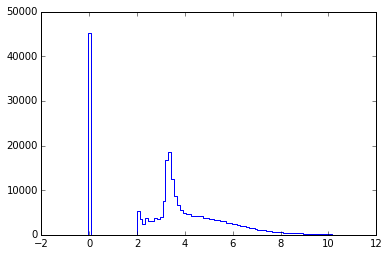

In [49]:
#d.factory.hist1d(n_sim_events,bins=100).line()
d.factory.hist1d(ts_values,bins=100).line()

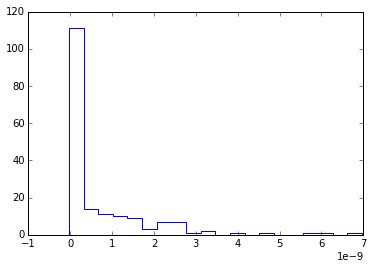

In [60]:
nz = n.nonzero(ts_values > 6)

d.factory.hist1d((container[nz[0][0]]),bins=20).line()

In [55]:
nz

(array([ 53763,  54165,  55036, ..., 209607, 215207, 220652]),)